In [18]:
from sklearn.datasets import load_boston
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import time

from sklearn import datasets, linear_model
from sklearn import metrics, cross_validation
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

In [19]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [20]:
type(boston)

sklearn.datasets.base.Bunch

In [21]:
print(boston.DESCR)
print(boston.keys())
print(boston.feature_names)
print(boston.data.shape)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [22]:
X = boston.data

In [23]:
X[0:2, :]

array([[  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
          0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
          6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
          2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
          4.98000000e+00],
       [  2.73100000e-02,   0.00000000e+00,   7.07000000e+00,
          0.00000000e+00,   4.69000000e-01,   6.42100000e+00,
          7.89000000e+01,   4.96710000e+00,   2.00000000e+00,
          2.42000000e+02,   1.78000000e+01,   3.96900000e+02,
          9.14000000e+00]])

In [24]:
y = boston.target

In [25]:
y[0:2]

array([ 24. ,  21.6])

## Prepare train/test sets

In [26]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.33, random_state = 5)

print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (339, 13)
y_train shape: (339,)
X_test shape: (167, 13)
y_test shape: (167,)


## Define linear regression functions

In [27]:
def predict(X, theta):
    return X.dot(theta.T)

def sum_squared_error(y, y_pred):
    square_of_errors = np.square(y_pred - y)
    return np.sum(square_of_errors)

def mean_squared_error(y, y_pred):
    m = y.shape[0]
    return (1 / (m)) * sum_squared_error(y, y_pred)
    
def gradient(X, y, y_pred):
    m = X.shape[0]
    error = y_pred - y
    gradient = (1/m) * X.T.dot(error)
    return (gradient, error)
    
def gradient_descent(X_y_gen, theta, alpha, iterations):
    thetas=[]
    errors=[]
    for it in range(iterations):
        for X, y in X_y_gen():
            m = X.shape[0]
            y_pred = predict(X, theta)
            grad, error = gradient(X, y, y_pred)
            theta = theta - (alpha * grad)
          
        thetas.append(theta)
        errors.append(error)
    
    log_gradient_descent_iterations(thetas, errors)
            
    return (theta, thetas)

def gradient_descent_stochastic(X_y_gen, theta, alpha, iterations):
    thetas=[]
    errors=[]
    for it in range(iterations):
        for X, y in X_y_gen():
            for i, _ in enumerate(X):
                X_i = X[i]
                y_i = y[i]
                y_i_pred = predict(X_i, theta)
                grad, error = gradient(X_i, y_i, y_i_pred)
                theta = theta - (alpha * grad)

        thetas.append(theta)
        errors.append(error)
    
    log_gradient_descent_iterations(thetas, errors)
        
    return (theta, thetas)


def all_gen(X, y):
    def lazy():
        X_shuf, y_shuf = shuffle(X, y)
        yield (X_shuf, y_shuf)
    return lazy
        
def batch_gen(X, y, batch_size):
    def lazy():
        X_shuf, y_shuf = shuffle(X, y)
        for i in range(0, len(y_shuf), batch_size):
            yield (X_shuf[i:i+batch_size,:], y_shuf[i:i+batch_size])
    return lazy

## Define helper functions

In [28]:
def plot_actual_over_predicted(y_actual, y_pred):
    plt.scatter(y_actual, y_pred)
    plt.plot([0, 50], [0, 50], '--k')
    plt.xlabel("Prices: $Y_i$")
    plt.ylabel("Predicted prices: $\hat{Y}_i$")
    plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

def plot_residuals(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    plt.scatter(y_pred_for_X_train, y_pred_for_X_train - y_train, c='b', s=40, alpha=0.5)
    plt.scatter(y_pred_for_X_test, y_pred_for_X_test - y_test, c='g', s=40)
    plt.hlines(y=0, xmin=0, xmax=50)
    plt.title('Residual plot using training (blue) and test (green) data')
    plt.ylabel('Residuals')
    plt.show()
    
def plot_costs(X, y, theta_history):
    iterations = range(len(theta_history))
    iter_costs = [mean_squared_error(y, predict(X, theta)) for theta in theta_history]        
    plt.plot(iterations, iter_costs)
    plt.xlabel('Iterations')
    plt.ylabel('Cost Function')
    plt.show()
    
def log_gradient_descent_iterations(thetas, errors):
     if (debug):
        for it, _ in enumerate(thetas): 
            print("Iteration: " + str(it))    
            print("  Theta: " + str(thetas[it]))
            print("  Error: " + str(errors[it]))
        
def calculate_cost_of_theta(X_train, y_train, X_test, y_test, theta):
    y_pred_for_X_train = predict(X_train, theta)
    y_pred_for_X_test = predict(X_test, theta)
    mse_on_train = mean_squared_error(y_train, y_pred_for_X_train)
    mse_on_test = mean_squared_error(y_test, y_pred_for_X_test)
    print('Theta: \n', theta)
    print("Mean squared error (train):", mse_on_train)
    print("Mean squared error (test):", mse_on_test)
        
def run_timed(func):
    start = time.clock()
    results = func()
    print("Time taken:", time.clock() - start)
    return results


## Test linear regression on limited data set

In [29]:
debug = True    

t_X = np.array([[1, 2, 3],[4, 5, 6]])
t_y = np.array([6, 15])
t_theta = np.array([2, 1, 1])
print("Theta: " + str(t_theta))

# Test cost function
t_y_pred = predict(t_X, t_theta)
cost = mean_squared_error(t_y, t_y_pred)
print("Cost: " + str(cost))
    
# Test gradient function
g, e = gradient(t_X, t_y, t_y_pred)
print("Gradient: " + str(g))

# Test gradient descent
print("\n")
print("Testing gradient descent")
t_initial_theta = np.array([4,3,2])
optimised_theta, _ = gradient_descent(all_gen(t_X, t_y), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent stochastic
print("\n")
print("Testing gradient descent stochastic")
optimised_theta, _ = gradient_descent_stochastic(all_gen(t_X, t_y), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

# Test gradient descent(mini batch)
print("\n")
print("Testing gradient descent mini batch")
optimised_theta, _ = gradient_descent(batch_gen(t_X, t_y, 2), t_initial_theta, 0.01, 100)
t_y_pred = predict(t_X, optimised_theta)
mse = mean_squared_error(t_y, t_y_pred)
print("Optimised theta: " + str(optimised_theta))
print("Optimised theta cost: " + str(mse))

Theta: [2 1 1]
Cost: 8.5
Gradient: [  8.5  11.   13.5]


Testing gradient descent
Iteration: 0
  Theta: [ 3.39  2.2   1.01]
  Error: [28 10]
Iteration: 1
  Theta: [ 3.0535  1.7613  0.4691]
  Error: [ 15.62   4.82]
Iteration: 2
  Theta: [ 2.866881   1.5205885  0.174296 ]
  Error: [ 8.8351  1.9834]
Iteration: 3
  Theta: [ 2.76240142  1.38837298  0.01434453]
  Error: [ 5.1162425  0.430946 ]
Iteration: 4
  Theta: [ 2.70293976  1.31561272 -0.07171431]
  Error: [-0.41781902  3.07753778]
Iteration: 5
  Theta: [ 2.66815391  1.27543408 -0.11728575]
  Error: [ 1.95953678 -0.88097773]
Iteration: 6
  Theta: [ 2.64689666  1.25311064 -0.14067537]
  Error: [ 1.34607155 -1.13283518]
Iteration: 7
  Theta: [ 2.63305945  1.24057253 -0.15191438]
  Error: [ 1.00908763 -1.26890816]
Iteration: 8
  Theta: [ 2.62329485  1.23339757 -0.15649972]
  Error: [-1.34153861  0.8236142 ]
Iteration: 9
  Theta: [ 2.61576852  1.22916243 -0.15744365]
  Error: [ 0.72116891 -1.37940918]
Iteration: 10
  Theta: [ 2.60947522  1.

## Run linear regression (ordinary least squares) from scikit-learn

<b>Provides some results to compare against</b>

Coefficients: 
 [ -1.56381297e-01   3.85490972e-02  -2.50629921e-02   7.86439684e-01
  -1.29469121e+01   4.00268857e+00  -1.16023395e-02  -1.36828811e+00
   3.41756915e-01  -1.35148823e-02  -9.88866034e-01   1.20588215e-02
  -4.72644280e-01]
Mean squared error (train): 19.55
Mean squared error (test): 28.54


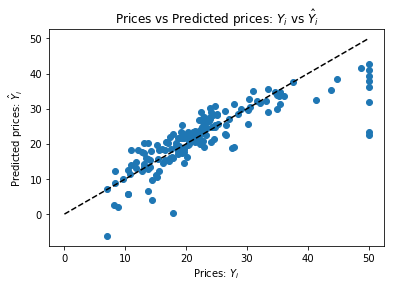

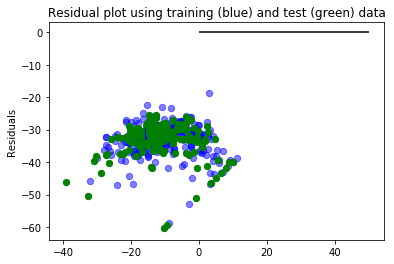

In [30]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, regr.coef_)

## Run stochastic gradient descent from scikit-learn

Coefficients: 
 [-0.14428983  0.09165823 -0.05008905  0.04142508  0.06105646  1.48206621
  0.08009115 -0.11399692  0.14033131 -0.00323082  0.41573312  0.02691314
 -0.7290495 ]
Mean squared error (train): 36.03
Mean squared error (test): 43.75


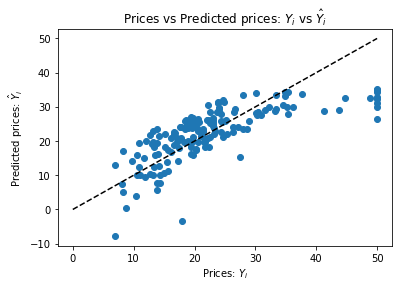

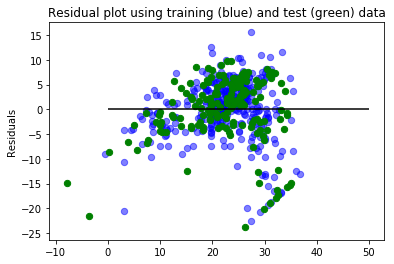

In [31]:
regr = linear_model.SGDRegressor(
    loss="squared_loss", 
    penalty=None, 
    eta0=0.000007,
    n_iter=4000)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print("Mean squared error (train): %.2f" % metrics.mean_squared_error(y_train, regr.predict(X_train)))
print("Mean squared error (test): %.2f" % metrics.mean_squared_error(y_test, y_pred))

plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, regr.coef_)

## Run linear regression with custom built gradient descent

Theta: 
 [ 0.51113797  0.98526683  0.50710326  0.62606847  0.56751125  0.26538561
  0.89027245  0.72294957  0.96229936  0.54369484  0.6784352   0.38867027
  0.76078942]
Mean squared error (train): 215946.232235
Mean squared error (test): 221199.163675


Time taken: 12.821668000000017
Theta: 
 [-0.14694891  0.08518218  0.03301421  0.64041145  0.59855954  1.15736939
  0.09577671  0.40171822  0.27553272 -0.0111458   0.39987193  0.02755712
 -0.76563049]
Mean squared error (train): 38.6813090943
Mean squared error (test): 46.1793136225


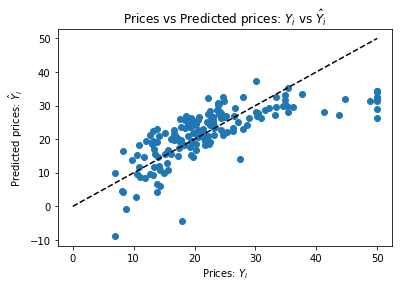

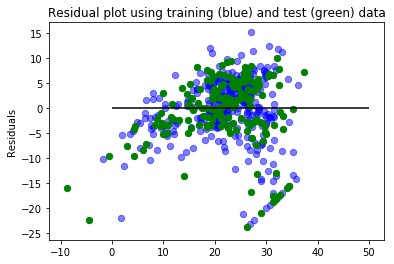

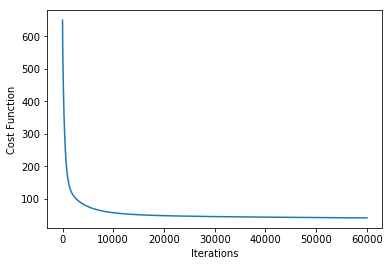

In [39]:
debug = False
num_of_iterations = 60000
alpha = 0.000004 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta, theta_history = run_timed(lambda: gradient_descent(all_gen(X_train, y_train), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)
plot_costs(X, y, theta_history[10:])

## Run linear regression with custom built stochastic gradient descent

Theta: 
 [ 0.41888808  0.37090954  0.10979537  0.77806565  0.13279364  0.40151277
  0.33938981  0.97606275  0.65217563  0.17031834  0.03528681  0.300072
  0.96299624]
Mean squared error (train): 45686.0596104
Mean squared error (test): 45961.5190692


Time taken: 13.666859000000017
Theta: 
 [-0.14640942  0.06296012 -0.0243216   0.8374457   0.27718855  3.68465067
  0.03356582 -0.35889408  0.19578829 -0.00809102 -0.06182018  0.01956098
 -0.55949262]
Mean squared error (train): 25.730394205
Mean squared error (test): 34.9657453324


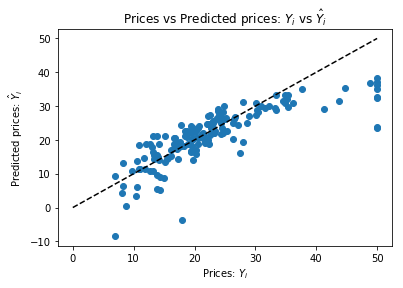

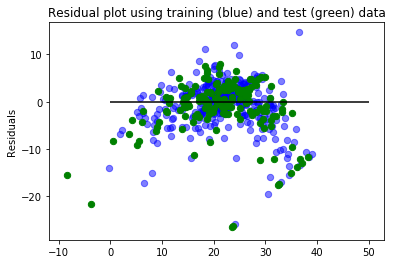

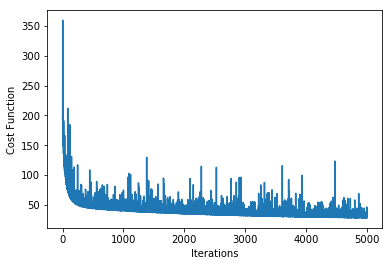

In [40]:
debug = False
num_of_iterations = 5000
alpha = 0.00001 # learning rate

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta, theta_history = run_timed(lambda: gradient_descent_stochastic(all_gen(X_train, y_train), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)
plot_costs(X, y, theta_history[2:])

## Run linear regression with custom built mini batch gradient descent

Theta: 
 [ 0.55912287  0.56820556  0.33870738  0.70286992  0.3492564   0.16449898
  0.8273023   0.61061775  0.44265171  0.14253385  0.66168383  0.97379759
  0.58660944]
Mean squared error (train): 236915.022202
Mean squared error (test): 234745.707216


Time taken: 12.623320000000007
Theta: 
 [-0.14910165  0.06777018 -0.03667245  0.77033818  0.49368356  3.5240504
  0.03476843 -0.45728846  0.18512995 -0.00940756  0.0061117   0.01758043
 -0.57093897]
Mean squared error (train): 30.537295938
Mean squared error (test): 40.9957757008


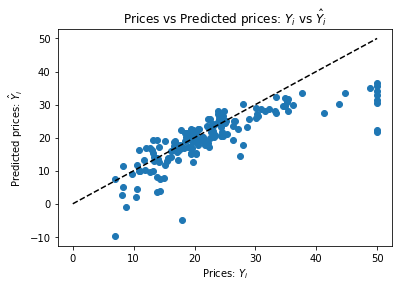

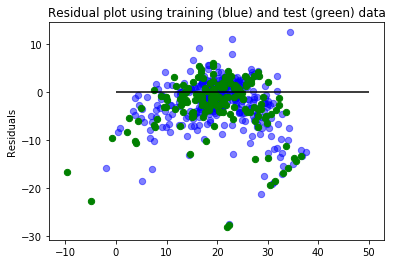

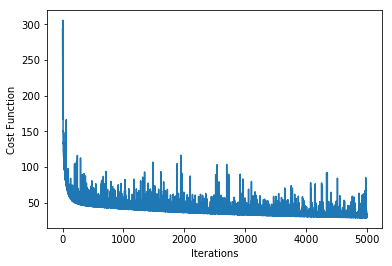

In [41]:
debug = False
num_of_iterations = 5000
alpha = 0.00001 # learning rate
batch_size = 50

initial_theta = np.random.rand((X.shape[1]))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, initial_theta)

print('\n')

optimised_theta, theta_history = run_timed(lambda: gradient_descent_stochastic(batch_gen(X_train, y_train, batch_size), initial_theta, alpha, num_of_iterations))
calculate_cost_of_theta(X_train, y_train, X_test, y_test, optimised_theta)

y_pred = X_test.dot(optimised_theta.T)
plot_actual_over_predicted(y_test, y_pred)
plot_residuals(X_train, y_train, X_test, y_test, optimised_theta)
plot_costs(X, y, theta_history[2:])

# Next steps

- Find which features are most important 
- Incorporate a stopping condition
- Reduce dimensions
- Use grid exhaustive search to optimise meta-parameters

# Resources

- Variants of gradient descent: http://ruder.io/optimizing-gradient-descent/
- Optimisation by grid exhaustive search: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html (this is *often* used to *jointly* select the best parameters of a model, i.e. the best learning rate, number of steps, learning rate decay, ...)
- Hyperopt library - gradient descent for meta parameter search